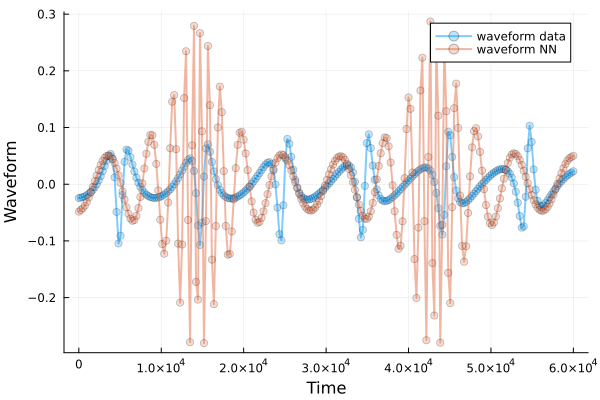

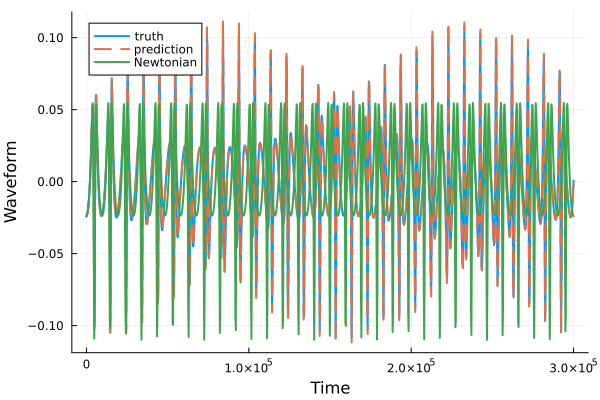

In [9]:
## BLACK HOLE Dynamics
## In this example, we will recover relativistic corrections to the Black hole dynamics


# SciML Tools
using OrdinaryDiffEq, ModelingToolkit, DataDrivenDiffEq, SciMLSensitivity, DataDrivenSparse
using Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs, DataFrames, CSV, LineSearches

using Random
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(1111)


#=
    ODE models for orbital mechanics
=#

function NewtonianOrbitModel(u, model_params, t)
    #=
        Defines system of odes which describes motion of
        point like particle with Newtonian physics, uses

        u[1] = χ
        u[2] = ϕ

        where, p, M, and e are constants
    =#
    χ, ϕ = u
    p, M, e = model_params

    numer = (1 + e * cos(χ))^2
    denom = M * (p^(3 / 2))

    χ̇ = numer / denom
    ϕ̇ = numer / denom

    return [χ̇, ϕ̇]

end

function RelativisticOrbitModel(u, model_params, t)
    #=
        Defines system of odes which describes motion of
        point like particle in schwarzschild background, uses

        u[1] = χ
        u[2] = ϕ

        where, p, M, and e are constants
    =#
    χ, ϕ = u
    p, M, e = model_params

    numer = (p - 2 - 2 * e * cos(χ)) * (1 + e * cos(χ))^2
    denom = sqrt((p - 2)^2 - 4 * e^2)

    χ̇ = numer * sqrt(p - 6 - 2 * e * cos(χ)) / (M * (p^2) * denom)
    ϕ̇ = numer / (M * (p^(3 / 2)) * denom)

    return [χ̇, ϕ̇]

end

function AbstractNNOrbitModel(u, model_params, t; NN=nothing, NN_params=nothing)
    #=
        Defines system of odes which describes motion of
        point like particle with Newtonian physics, uses

        u[1] = χ
        u[2] = ϕ

        where, p, M, and e are constants
    =#
    χ, ϕ = u
    p, M, e = model_params

    if isnothing(NN)
        nn = [1, 1]
    else
        nn = 1 .+ NN([u[1]], NN_params, st)[1]
    end

    numer = (1 + e * cos(χ))^2
    denom = M * (p^(3 / 2))

    χ̇ = (numer / denom) * nn[1]
    ϕ̇ = (numer / denom) * nn[2]

    return [χ̇, ϕ̇]

end



#=
    Axiliary functions for orbital mechanics
=#
using DelimitedFiles

function soln2orbit(soln, model_params=nothing)
    #=
        Performs change of variables:
        (χ(t),ϕ(t)) ↦ (x(t),y(t))
    =#
    if size(soln, 1) == 2
        χ = soln[1, :]
        ϕ = soln[2, :]
        if length(model_params) == 3
            p, M, e = model_params
        else
            error("model_params must have length 3 when size(soln,2) = 2")
        end
    elseif size(soln, 1) == 4
        χ = soln[1, :]
        ϕ = soln[2, :]
        p = soln[3, :]
        e = soln[4, :]
    else
        error("size(soln,2) must be either 2 or 4")
    end

    r = p ./ (1 .+ e .* cos.(χ))
    x = r .* cos.(ϕ)
    y = r .* sin.(ϕ)

    orbit = vcat(x', y')
    return orbit
end

function orbit2tensor(orbit, component, mass=1.0)
    #=
        Construct trace-free moment tensor Ι(t) for orbit from BH orbit (x(t),y(t))

        component defines the Cartesion indices in x,y. For example,
        I_{22} is the yy component of the moment tensor.
    =#
    x = orbit[1, :]
    y = orbit[2, :]

    Ixx = x .^ 2
    Iyy = y .^ 2
    Ixy = x .* y
    trace = Ixx .+ Iyy

    if component[1] == 1 && component[2] == 1
        tmp = Ixx .- (1.0 ./ 3.0) .* trace
    elseif component[1] == 2 && component[2] == 2
        tmp = Iyy .- (1.0 ./ 3.0) .* trace
    else
        tmp = Ixy
    end

    return mass .* tmp
end

function d_dt(v::AbstractVector, dt)
    # uses second-order one-sided difference stencils at the endpoints; see https://doi.org/10.1090/S0025-5718-1988-0935077-0
    a = -3 / 2 * v[1] + 2 * v[2] - 1 / 2 * v[3]
    b = (v[3:end] .- v[1:end-2]) / 2
    c = 3 / 2 * v[end] - 2 * v[end-1] + 1 / 2 * v[end-2]
    return [a; b; c] / dt
end

function d2_dt2(v::AbstractVector, dt)
    # uses second-order one-sided difference stencils at the endpoints; see https://doi.org/10.1090/S0025-5718-1988-0935077-0
    a = 2 * v[1] - 5 * v[2] + 4 * v[3] - v[4]
    b = v[1:end-2] .- 2 * v[2:end-1] .+ v[3:end]
    c = 2 * v[end] - 5 * v[end-1] + 4 * v[end-2] - v[end-3]
    return [a; b; c] / (dt^2)
end

function h_22_quadrupole_components(dt, orbit, component, mass=1.0)
    #=
        x(t) and y(t) inputs are the trajectory of the orbiting BH.

       WARNING: assuming x and y are on a uniform grid of spacing dt
        x_index and y_index are 1,2,3 for x, y, and z indicies.
    =#

    mtensor = orbit2tensor(orbit, component, mass)
    mtensor_ddot = d2_dt2(mtensor, dt)

    # return mtensor
    return 2 * mtensor_ddot
end

function h_22_quadrupole(dt, orbit, mass=1.0)
    h11 = h_22_quadrupole_components(dt, orbit, (1, 1), mass)
    h22 = h_22_quadrupole_components(dt, orbit, (2, 2), mass)
    h12 = h_22_quadrupole_components(dt, orbit, (1, 2), mass)
    return h11, h12, h22
end

function h_22_strain_one_body(dt, orbit)

    h11, h12, h22 = h_22_quadrupole(dt, orbit)

    h₊ = h11 - h22
    hₓ = 2.0 * h12

    scaling_const = sqrt(pi / 5)
    return scaling_const * h₊, -scaling_const * hₓ
end

function h_22_quadrupole_two_body(dt, orbit1, mass1, orbit2, mass2)
    h11_1, h12_1, h22_1 = h_22_quadrupole(dt, orbit1, mass1)
    h11_2, h12_2, h22_2 = h_22_quadrupole(dt, orbit2, mass2)
    h11 = h11_1 + h11_2
    h12 = h12_1 + h12_2
    h22 = h22_1 + h22_2
    return h11, h12, h22
end

function h_22_strain_two_body(dt, orbit1, mass1, orbit2, mass2)
    # compute (2,2) mode strain from orbits of BH 1 of mass1 and BH2 of mass 2

    @assert abs(mass1 + mass2 - 1.0) < 1e-12 "Masses do not sum to unity"

    h11, h12, h22 = h_22_quadrupole_two_body(dt, orbit1, mass1, orbit2, mass2)

    h₊ = h11 - h22
    hₓ = 2.0 * h12

    scaling_const = sqrt(pi / 5)
    return scaling_const * h₊, -scaling_const * hₓ
end

function one2two(path, m1, m2)
    #=
        We need a very crude 2-body path

        Assume the 1-body motion is a newtonian 2-body position vector r = r1 - r2
        and use Newtonian formulas to get r1, r2
        (e.g. Theoretical Mechanics of Particles and Continua 4.3)
    =#

    M = m1 + m2
    r1 = m2 / M .* path
    r2 = -m1 / M .* path

    return r1, r2
end

function compute_waveform(dt, soln, mass_ratio, model_params=nothing)

    @assert mass_ratio <= 1.0 "mass_ratio must be <= 1"
    @assert mass_ratio >= 0.0 "mass_ratio must be non-negative"

    orbit = soln2orbit(soln, model_params)
    if mass_ratio > 0
        mass1 = mass_ratio / (1.0 + mass_ratio)
        mass2 = 1.0 / (1.0 + mass_ratio)

        orbit1, orbit2 = one2two(orbit, mass1, mass2)
        waveform = h_22_strain_two_body(dt, orbit1, mass1, orbit2, mass2)
    else
        waveform = h_22_strain_one_body(dt, orbit)
    end
    return waveform
end

function interpolate_time_series(tsteps, tdata, fdata)

    @assert length(tdata) == length(fdata) "lengths of tdata and fdata must match"

    interp_fdata = zeros(length(tsteps))
    for j = 1:length(tsteps)
        for i = 1:length(tdata)-1
            if tdata[i] <= tsteps[j] < tdata[i+1]
                weight = (tsteps[j] - tdata[i]) / (tdata[i+1] - tdata[i])
                interp_fdata[j] = (1 - weight) * fdata[i] + weight * fdata[i+1]
                break
            end
        end
    end

    return interp_fdata
end

function file2waveform(tsteps, filename="waveform.txt")

    # read in file
    f = open(filename, "r")
    data = readdlm(f)
    tdata = data[:, 1]
    wdata = data[:, 2]

    # interpolate data to tsteps
    waveform = interpolate_time_series(tsteps, tdata, wdata)

    return waveform
end

function file2trajectory(tsteps, filename="trajectoryA.txt")

    # read in file
    f = open(filename, "r")
    data = readdlm(f)
    tdata = data[:, 1]
    xdata = data[:, 2]
    ydata = data[:, 3]

    # interpolate data to tsteps
    x = interpolate_time_series(tsteps, tdata, xdata)
    y = interpolate_time_series(tsteps, tdata, ydata)

    return x, y
end

##### STEP 1: GENERATE UNDERLYING DATA

mass_ratio = 0.0         # test particle
u0 = Float64[pi, 0.0]    # initial conditions
datasize = 250
tspan = (0.0f0, 6.0f4)   # timespace for GW waveform
tsteps = range(tspan[1], tspan[2], length = datasize)  # time at each timestep
dt_data = tsteps[2] - tsteps[1]
dt = 100.0
model_params = [100.0, 1.0, 0.5]; # p, M, e

prob = ODEProblem(RelativisticOrbitModel, u0, tspan, model_params)
soln = Array(solve(prob, RK4(), saveat = tsteps, dt = dt, adaptive=false))
waveform = compute_waveform(dt_data, soln, mass_ratio, model_params)[1]
plt = plot(tsteps, waveform,
           markershape=:circle, markeralpha = 0.25,
           linewidth = 2, alpha = 0.5,
           label="waveform data", xlabel="Time", ylabel="Waveform")

           NN = Lux.Chain((x) -> cos.(x),
           Lux.Dense(1, 32, cos),
           Lux.Dense(32, 32, cos),
           Lux.Dense(32, 2))
       p, st = Lux.setup(rng, NN)
       NN_params = ComponentArray{Float64}(p)
       
       function ODE_model(u, NN_params, t)
           du = AbstractNNOrbitModel(u, model_params, t, NN=NN, NN_params=NN_params)
           return du
       end

       prob_nn = ODEProblem(ODE_model, u0, tspan, NN_params)
       soln_nn = Array(solve(prob_nn, RK4(), u0 = u0, p = NN_params, saveat = tsteps, dt = dt, adaptive=false))
       waveform_nn = compute_waveform(dt_data, soln_nn, mass_ratio, model_params)[1]
       plot!(plt, tsteps, waveform_nn,
                  markershape=:circle, markeralpha = 0.25,
                  linewidth = 2, alpha = 0.5,
                  label="waveform NN")
       display(plt)

       function loss(NN_params)
        first_obs_to_use_for_training = 1
        last_obs_to_use_for_training = length(waveform)
        obs_to_use_for_training = first_obs_to_use_for_training:last_obs_to_use_for_training
    
        pred = Array(solve(prob_nn, RK4(), u0 = u0, p = NN_params, saveat = tsteps, dt = dt, adaptive=false))
        pred_waveform = compute_waveform(dt_data, pred, mass_ratio, model_params)[1]
    
        loss = ( sum(abs2, view(waveform,obs_to_use_for_training) .- view(pred_waveform,obs_to_use_for_training) ) )
        return loss, pred_waveform
    end

    loss(NN_params)


    losses = []

callback(θ,l,pred_waveform; doplot = true) = begin
    push!(losses, l)
    #=  Disable plotting as it trains since in docs
    display(l)
    # plot current prediction against data
    plt = plot(tsteps, waveform,
        markershape=:circle, markeralpha = 0.25,
        linewidth = 2, alpha = 0.5,
        label="wform data (h22)", legend=:topleft)
    plot!(plt, tsteps, pred_waveform,
        markershape=:circle, markeralpha = 0.25,
        linewidth = 2, alpha = 0.5,
        label = "wform NN")
    if doplot
        display(plot(plt))
    end
    # Tell sciml_train to not halt the optimization. If return true, then
    # optimization stops.
    =#
    return false
end


## RUNNING THE TRAINING PROCESS
##The next cell initializes the weights of the neural network and then trains the neural network. Training uses the BFGS optimizers. This seems to give good results because the Newtonian model seems to give a very good initial guess.

NN_params = NN_params .* 0 + Float64(1e-4) * randn(StableRNG(2031), eltype(NN_params), size(NN_params))

adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(NN_params))
res1 = Optimization.solve(optprob, OptimizationOptimisers.Adam(0.001f0), callback=callback, maxiters=100)
optprob = Optimization.OptimizationProblem(optf, res1.u)
res2 = Optimization.solve(optprob, BFGS(initial_stepnorm=0.01, linesearch=LineSearches.BackTracking()), callback=callback, maxiters=20)


#### Comparing the true data, Newtonian model and Neural ODE prediction
reference_solution = solve(remake(prob, p = model_params, saveat = tsteps, tspan=tspan),
                            RK4(), dt = dt, adaptive=false)

optimized_solution = solve(remake(prob_nn, p = res2.minimizer, saveat = tsteps, tspan=tspan),
                            RK4(), dt = dt, adaptive=false)
Newtonian_prob = ODEProblem(NewtonianOrbitModel, u0, tspan, model_params)

Newtonian_solution = solve(remake(Newtonian_prob, p = model_params, saveat = tsteps, tspan=tspan),
                            RK4(), dt = dt, adaptive=false)

true_orbit = soln2orbit(reference_solution, model_params)
pred_orbit = soln2orbit(optimized_solution, model_params)
Newt_orbit = soln2orbit(Newtonian_solution, model_params)

true_waveform = compute_waveform(dt_data, reference_solution, mass_ratio, model_params)[1]
pred_waveform = compute_waveform(dt_data, optimized_solution, mass_ratio, model_params)[1]
Newt_waveform = compute_waveform(dt_data, Newtonian_solution, mass_ratio, model_params)[1]

true_orbit = soln2orbit(reference_solution, model_params)
pred_orbit = soln2orbit(optimized_solution, model_params)
Newt_orbit = soln2orbit(Newtonian_solution, model_params)
plt = plot(true_orbit[1,:], true_orbit[2,:], linewidth = 2, label = "truth")
plot!(plt, pred_orbit[1,:], pred_orbit[2,:], linestyle = :dash, linewidth = 2, label = "prediction")
plot!(plt, Newt_orbit[1,:], Newt_orbit[2,:], linewidth = 2, label = "Newtonian")


plt = plot(tsteps,true_waveform, linewidth = 2, label = "truth", xlabel="Time", ylabel="Waveform")
plot!(plt,tsteps,pred_waveform, linestyle = :dash, linewidth = 2, label = "prediction")
plot!(plt,tsteps,Newt_waveform, linewidth = 2, label = "Newtonian")


####Forecasting
factor=5

extended_tspan = (tspan[1], factor*tspan[2])
extended_tsteps = range(tspan[1], factor*tspan[2], length = factor*datasize)
reference_solution = solve(remake(prob, p = model_params, saveat = extended_tsteps, tspan=extended_tspan),
                            RK4(), dt = dt, adaptive=false)
optimized_solution = solve(remake(prob_nn, p = res2.minimizer, saveat = extended_tsteps, tspan=extended_tspan),
                            RK4(), dt = dt, adaptive=false)
Newtonian_prob = ODEProblem(NewtonianOrbitModel, u0, tspan, model_params)
Newtonian_solution = solve(remake(Newtonian_prob, p = model_params, saveat = extended_tsteps, tspan=extended_tspan),
                            RK4(), dt = dt, adaptive=false)
true_orbit = soln2orbit(reference_solution, model_params)
pred_orbit = soln2orbit(optimized_solution, model_params)
Newt_orbit = soln2orbit(Newtonian_solution, model_params)
plt = plot(true_orbit[1,:], true_orbit[2,:], linewidth = 2, label = "truth")
plot!(plt, pred_orbit[1,:], pred_orbit[2,:], linestyle = :dash, linewidth = 2, label = "prediction")
plot!(plt, Newt_orbit[1,:], Newt_orbit[2,:], linewidth = 2, label = "Newtonian")

true_waveform = compute_waveform(dt_data, reference_solution, mass_ratio, model_params)[1]
pred_waveform = compute_waveform(dt_data, optimized_solution, mass_ratio, model_params)[1]
Newt_waveform = compute_waveform(dt_data, Newtonian_solution, mass_ratio, model_params)[1]
plt = plot(extended_tsteps,true_waveform, linewidth = 2, label = "truth", xlabel="Time", ylabel="Waveform")
plot!(plt,extended_tsteps,pred_waveform, linestyle = :dash, linewidth = 2, label = "prediction")
plot!(plt,extended_tsteps,Newt_waveform, linewidth = 2, label = "Newtonian")